In [3]:
!pip install -q condacolab
import condacolab
condacolab.install()

✨🍰✨ Everything looks OK!


In [4]:
from google.colab import drive
# Mount Drive to access the YAML file
drive.mount('/content/drive', force_remount=True)

# Re-create the environment from the YAML file
# The 'source' command is NOT needed here because condacolab handles PATH setup.
!conda env create -f "/content/drive/MyDrive/GDS/envs363-563.yml"

Mounted at /content/drive

CondaValueError: prefix already exists: /usr/local/envs/envs363-563



In [5]:

!source /usr/local/etc/profile.d/conda.sh && conda activate envs363-563 && conda install ipykernel -y && ipython kernel install --user --name envs363-563

Channels:
 - conda-forge
 - defaults
Platform: linux-64
Solving environment: | / - done


==> WARNING: A newer version of conda exists. <==
    current version: 24.11.2
    latest version: 25.9.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



## Package Plan ##

  environment location: /usr/local/envs/envs363-563

  added / updated specs:
    - ipykernel


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    asttokens-3.0.0            |     pyhd8ed1ab_1          28 KB  conda-forge
    ca-certificates-2025.10.5  |       hbd8a1cb_0         152 KB  conda-forge
    comm-0.2.3                 |     pyhe01879c_0          14 KB  conda-forge
    debugpy-1.8.17             |  py311hc665b79_0         2.6 MB  conda-forge
    decorator-5.2.1            |     pyhd8ed1ab_0          14 KB  conda-forge
    exceptiongroup-1.3.0       |     pyhd8ed1ab_0          21 KB

In [9]:
!conda activate envs363-563 && conda install ipykernel -y && ipython kernel install --user --name envs363-563


CondaError: Run 'conda init' before 'conda activate'



To begin this project I analyse the data. I open and check the rasters metadata, analysing their CRS, pixelation and min/max data value.

In [ ]:
import rasterio
import numpy as np
import os

# --- Configuration ---

# 2025 Population Count GeoTIFF (input file for population raster)
FILEPATH_2025 = r"/content/drive/MyDrive/GDS/global_pop_2025_CN_1km_R2025A_UA_v1.tif"
# 2015 Population Count GeoTIFF (input file for population raster)
FILEPATH_2015 = r"/content/drive/MyDrive/GDS/global_pop_2015_CN_1km_R2025A_UA_v1.tif"

def load_raster_data(filepath: str, year: int) -> Tuple[Optional[np.ndarray], Optional[Dict]]:
    """Opens a GeoTIFF, prints key metadata, and returns data array and profile."""
    if not exists(filepath):
        print(f"ERROR: File not found: {filepath}")
        return None, None

    try:
        with rasterio.open(filepath) as src:
            # 1. Extract Data
            data_array = src.read(1)
            profile = src.profile # Contains all metadata (CRS, transform, etc.)

            # 2. Print Condensed Metadata
            print(f"\n✅ Successfully Loaded {year} Data.")
            print(f"   Shape: {data_array.shape}")
            print(f"   CRS: {src.crs.to_string() if src.crs else 'N/A'}")
            print(f"   Value Range: Min={np.min(data_array):.2f}, Max={np.max(data_array):.2f}")

            return data_array, profile

    except Exception as e:
        print(f"⚠️ An error occurred while processing {filepath}: {e}")
        return None, None

# Load 2025 data/metadata
pop_2025_array, profile_2025 = load_raster_data(FILEPATH_2025, 2025)

# Load 2015 data/metadata
pop_2015_array, profile_2015 = load_raster_data(FILEPATH_2015, 2015)

# --- Check for Success for next step  ---

if pop_2025_array is not None and pop_2015_array is not None:
    print("\nProcessing ready. Now you can perform calculations like array subtraction.")
    # Example Calculation (Population Change)
    pop_change = pop_2025_array - pop_2015_array
    print(f"Population Change Array Created: {pop_change.shape}")


  Metadata for Population Count 2025
CRS (Coordinate System): EPSG:4326
Resolution (Pixel Size): (0.0083333333, 0.0083333333)
Width x Height (Pixels): 43200 x 17280
Data Type (Pixel Values): float32
NoData Value (Mask): -99999.0
Bounds (Extent): BoundingBox(left=-180.0, bottom=-59.99999942400001, right=179.99999856000005, top=84.0)

--- Data Array Information ---
Data Shape: (17280, 43200)
Min Population Value: -99999.0
Max Population Value: 107776.3046875

  Metadata for Population Count 2015
CRS (Coordinate System): EPSG:4326
Resolution (Pixel Size): (0.0083333333, 0.0083333333)
Width x Height (Pixels): 43200 x 17280
Data Type (Pixel Values): float32
NoData Value (Mask): -99999.0
Bounds (Extent): BoundingBox(left=-180.0, bottom=-59.99999942400001, right=179.99999856000005, top=84.0)

--- Data Array Information ---
Data Shape: (17280, 43200)
Min Population Value: -99999.0
Max Population Value: 105077.734375

Successfully loaded both raster datasets. You are ready to proceed to clippi

This metadata shows that geographic co-ordinates (CRS:EPSG) is used not a projected coordinate system. This means the vector data needed to be a shapefileto ensure the layers align.

In [5]:
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
from rasterio.plot import show
import numpy as np
import os
import matplotlib.colors as mcolors

# --- Configuration  ---
OUTPUT_DIR = "final_output_data"

# File paths for final datasets (these exist in your output folder)
DENSITY_SHAPEFILE = os.path.join(OUTPUT_DIR, "map1_density_by_region.shp")
CHANGE_RASTER_FILE = os.path.join(OUTPUT_DIR, "map2_categorical_change.tif")
LEVEL0_SHAPEFILE = os.path.join(OUTPUT_DIR, "africa_admin_level0_eqarea.shp")

# --- Custom Legend Label Function (Defined above in chat history) ---
def legend_label_format(value_list):
    """Formats legend labels to use 'min - max' with dashes for readability."""
    labels = []

    # 1. Label for the lowest class (0 to first break)
    labels.append(f"0 - {value_list[0]:,.0f}")

    # 2. Format intermediate breaks as "Min - Max"
    for i in range(len(value_list) - 1):
        min_val = value_list[i]
        max_val = value_list[i+1]
        # Use comma as thousands separator for readability
        labels.append(f"{min_val:,.0f} - {max_val:,.0f}")

    # 3. Label for the highest class (> last break)
    labels.append(f">{value_list[-1]:,.0f}")

    return labels

# --- Map 1: Population Density Visualization ---

def plot_density_map(density_gdf, level0_gdf, country_column_name):
    """Generates the average population density map (Map 1)."""

    # Column name confirmed to be truncated to 10 characters by Shapefile format
    column_name = 'AVG_POP_DE'

    if column_name not in density_gdf.columns:
        print(f"\n--- DEBUG: CRITICAL ---")
        print("The expected density column was not found. Available columns:", list(density_gdf.columns))
        raise KeyError(f"Required column '{column_name}' missing. Please ensure your analysis script completed successfully.")

    try:
        fig, ax = plt.subplots(1, 1, figsize=(12, 12))

        # --- High Contrast Color Scheme: PuBuGn (Purple-Blue-Green) ---
        cmap_name = 'PuBuGn'

        # 6 breaks create 7 classes, capturing up to the highest density of 115,000+
        custom_breaks = [10, 100, 500, 2500, 15000, 115000]

        # Plot Map 1: Population Density by Region (Level 1)
        density_gdf.plot(
            column=column_name,
            ax=ax,
            legend=True,
            cmap=cmap_name,
            scheme='UserDefined',
            classification_kwds={'bins': custom_breaks},
            legend_kwds={
                'loc': 'lower left',
                'title': 'Avg. Population Density (Ppl/km²)',
                'labels': legend_label_format(custom_breaks), # Custom dashed labels
                'bbox_to_anchor': (0.05, 0.05),
                'frameon': False
            }
        )

        # --- FIX: Overriding Legend Elements to include "No Data" as blank/white ---

        # Get the color map and number of classes used by geopandas (should be 7)
        cmap = ax.collections[0].cmap
        num_classes = len(ax.collections[0].get_facecolors())

        # Create legend elements for the classes (7 color boxes)
        legend_elements = [plt.Rectangle((0, 0), 1, 1, fc=ax.collections[0].get_facecolors()[i]) for i in range(num_classes)]

        # Add the "No Data" element (white/blank box)
        legend_elements.append(plt.Rectangle((0, 0), 1, 1, fc='white', edgecolor='black', linewidth=0.5))

        # Get the labels (7 dashed labels)
        labels = [text.get_text() for text in ax.get_legend().get_texts()]

        # Add the "No Data" label
        labels.append("No Data")

        # Hide old legend and create new custom one
        ax.get_legend().remove()
        ax.legend(
            legend_elements,
            labels,
            loc='lower left',
            title='Avg. Population Density (Ppl/km²)',
            bbox_to_anchor=(0.05, 0.05),
            frameon=False
        )

        # Overlay Map: Country Boundaries (Level 0) for context
        level0_gdf.boundary.plot(ax=ax, linewidth=0.5, color='gray', alpha=0.5)

        ax.set_title(
            "Map 1: Average Population Density by Region in West Africa (2025)",
            fontsize=16,
            fontweight='bold'
        )
        ax.set_axis_off()
        plt.tight_layout()

    except KeyError as e:
        raise KeyError(f"Failed to plot Map 1. Ensure the column '{column_name}' is correct: {e}")


# --- Map 2: Categorical Change Visualization (Defined above in chat history) ---

def plot_change_map(change_raster_file, level0_gdf):
    """Generates the categorical population change map (Map 2)."""

    # 1. Load the Raster data
    with rasterio.open(change_raster_file) as src:
        change_array = src.read(1)
        profile = src.profile

    # Define custom colors and labels for the 4 categories (must match the analysis script)

    # Categories: 1=Decline, 2=Neutral, 3=Growth, 4=High Growth (NoData=99)
    # Define colors for these categories
    cmap = mcolors.ListedColormap(['#d73027', '#ffffbf', '#91cf60', '#1a9850']) # Red to Green diverging
    bounds = [0.5, 1.5, 2.5, 3.5, 4.5] # Bins for discrete categories
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    fig, ax = plt.subplots(1, 1, figsize=(12, 12))

    # Plot Map 2: Categorical Change Raster
    show(
        change_array,
        transform=profile['transform'],
        ax=ax,
        cmap=cmap,
        norm=norm,
        interpolation='nearest'
    )

    # Overlay Map: Country Boundaries (Level 0) for context
    level0_gdf.boundary.plot(ax=ax, linewidth=0.5, color='black', alpha=0.7)

    # Create Custom Legend
    legend_elements = [
        plt.Rectangle((0, 0), 1, 1, fc='#d73027'),
        plt.Rectangle((0, 0), 1, 1, fc='#ffffbf'),
        plt.Rectangle((0, 0), 1, 1, fc='#91cf60'),
        plt.Rectangle((0, 0), 1, 1, fc='#1a9850')
    ]
    labels = ['1. Decline (Pop. Loss)', '2. Neutral (Small Change)', '3. Growth (Moderate Gain)', '4. High Growth (Large Gain)']

    ax.legend(
        legend_elements,
        labels,
        loc='lower left',
        title="Population Change Category",
        bbox_to_anchor=(0.05, 0.05),
        frameon=False
    )

    ax.set_title(
        "Map 2: Categorical Population Change in West Africa (2015-2025)",
        fontsize=16,
        fontweight='bold'
    )
    ax.set_axis_off()
    plt.tight_layout()


# --- Execution ---

def main_plot():

    if not os.path.exists(DENSITY_SHAPEFILE) or not os.path.exists(LEVEL0_SHAPEFILE):
        print("❌ ERROR: Required files not found. Please ensure 'final_analysis.py' ran successfully.")
        return

    # Load all required layers
    density_gdf = gpd.read_file(DENSITY_SHAPEFILE)
    level0_gdf = gpd.read_file(LEVEL0_SHAPEFILE)

    print("\n--- Level 1 Density GeoDataFrame Head (L1 Regions & Density) ---")
    # Print the head of the density GeoDataFrame
    print(density_gdf.head(20))

    print("\n--- Level 0 Country Borders GeoDataFrame Head (L0 Countries) ---")
    # Print the head of the country borders GeoDataFrame
    print(level0_gdf.head(20))

    print("\n------------------------------------------------------")
    print("✅ Please examine the 'head' output above to identify the correct country name column (e.g., NAME_EN, ADM0_NAME, or similar).")

    # Note: The code will halt here (as intended for debugging)

if __name__ == '__main__':
    main_plot()


ModuleNotFoundError: No module named 'rasterio'

In [6]:
!pip install matplotlib-scalebar

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl.metadata (8.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 119.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 89.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 61.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 101.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 92.8 MB/s eta 0:00:00


In [7]:
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
from rasterio.plot import show
import numpy as np
import os
import matplotlib.colors as mcolors

# --- Configuration (Keep existing settings) ---
OUTPUT_DIR = "final_output_data"

# File paths for final datasets (these exist in your output folder)
DENSITY_SHAPEFILE = os.path.join(OUTPUT_DIR, "map1_density_by_region.shp")
CHANGE_RASTER_FILE = os.path.join(OUTPUT_DIR, "map2_categorical_change.tif")
LEVEL0_SHAPEFILE = os.path.join(OUTPUT_DIR, "africa_admin_level0_eqarea.shp")

# --- Custom Legend Label Function (FIXED to return N labels for N breaks) ---
def legend_label_format(value_list):
    """Formats legend labels to use 'min - max' with dashes for readability.

       FIX: Only generate N labels for N breaks to avoid mapclassify ValueError.
       We will manually define the highest label after the fact.
    """
    labels = []

    # 1. Label for the lowest class (0 to first break)
    labels.append(f"0 - {value_list[0]:,.0f}")

    # 2. Format intermediate breaks as "Min - Max"
    # Iterate N-1 times (N=6 breaks means 5 intermediate ranges + the lowest range)
    for i in range(len(value_list) - 1):
        min_val = value_list[i]
        max_val = value_list[i+1]
        # Use comma as thousands separator for readability
        labels.append(f"{min_val:,.0f} - {max_val:,.0f}")

    # **CRITICAL CHANGE**: We omit the label for the final (7th) class here,
    # as mapclassify is incorrectly requesting N labels for N breaks.

    return labels[:len(value_list)] # Return exactly N (6) labels

# --- Map 1: Population Density Visualization ---

def plot_density_map(density_gdf, level0_gdf):
    """Generates the average population density map (Map 1)."""

    # Confirmed column names
    column_name = 'AVG_POP_DE'

    if column_name not in density_gdf.columns:
        print(f"\n--- DEBUG: CRITICAL ---")
        print("The expected density column was not found. Available columns:", list(density_gdf.columns))
        raise KeyError(f"Required density column '{column_name}' missing. Please ensure your analysis script completed successfully.")

    try:
        fig, ax = plt.subplots(1, 1, figsize=(12, 12))

        # --- High Contrast Color Scheme: PuBuGn (Purple-Blue-Green) ---
        cmap_name = 'PuBuGn'

        # 6 breaks create 7 classes, capturing up to the highest density of 115,000+
        custom_breaks = [10, 100, 500, 2500, 15000, 115000]

        # Plot Map 1: Population Density by Region (Level 1)
        density_gdf.plot(
            column=column_name,
            ax=ax,
            legend=True,
            cmap=cmap_name,
            scheme='UserDefined',
            classification_kwds={'bins': custom_breaks},
            legend_kwds={
                'loc': 'lower left',
                'title': 'Avg. Population Density (Ppl/km²)',
                'labels': legend_label_format(custom_breaks), # Custom labels (now 6)
                'bbox_to_anchor': (0.05, 0.05),
                'frameon': False
            }
        )

        # --- Post-Plot Legend Fix (Manual Override) ---

        # 1. Get the 7 class labels generated by geopandas (it uses the 6 labels provided,
        #    but the last label usually defaults/wraps to the highest class)
        labels = [text.get_text() for text in ax.get_legend().get_texts()]

        # 2. Manually fix the final label to show the correct > break value
        labels[-1] = f">{custom_breaks[-1]:,.0f}" # Should now read ">115,000"

        # 3. Handle No Data Legend Element
        cmap = ax.collections[0].cmap
        num_classes = len(labels) # Now 7 classes

        legend_elements = [plt.Rectangle((0, 0), 1, 1, fc=ax.collections[0].get_facecolors()[i]) for i in range(num_classes)]
        legend_elements.append(plt.Rectangle((0, 0), 1, 1, fc='white', edgecolor='black', linewidth=0.5))
        labels.append("No Data")

        # 4. Re-draw final custom legend
        ax.get_legend().remove()
        ax.legend(
            legend_elements,
            labels,
            loc='lower left',
            title='Avg. Population Density (Ppl/km²)',
            bbox_to_anchor=(0.05, 0.05),
            frameon=False
        )

        # Overlay Map: Country Boundaries (Level 0) for context
        level0_gdf.boundary.plot(ax=ax, linewidth=0.5, color='gray', alpha=0.5)

        ax.set_title(
            "Map 1: Average Population Density by Region in West Africa (2025)",
            fontsize=16,
            fontweight='bold'
        )
        ax.set_axis_off()
        plt.tight_layout()

    except KeyError as e:
        raise KeyError(f"Failed to plot Map 1: {e}")


# --- Map 2: Categorical Change Visualization (Defined above in chat history) ---

def plot_change_map(change_raster_file, level0_gdf):
    """Generates the categorical population change map (Map 2)."""

    # 1. Load the Raster data
    with rasterio.open(change_raster_file) as src:
        change_array = src.read(1)
        profile = src.profile

    # Define custom colors and labels for the 4 categories (must match the analysis script)

    # Categories: 1=Decline, 2=Neutral, 3=Growth, 4=High Growth (NoData=99)
    # Define colors for these categories
    cmap = mcolors.ListedColormap(['#d73027', '#ffffbf', '#91cf60', '#1a9850']) # Red to Green diverging
    bounds = [0.5, 1.5, 2.5, 3.5, 4.5] # Bins for discrete categories
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    fig, ax = plt.subplots(1, 1, figsize=(12, 12))

    # Plot Map 2: Categorical Change Raster
    show(
        change_array,
        transform=profile['transform'],
        ax=ax,
        cmap=cmap,
        norm=norm,
        interpolation='nearest'
    )

    # Overlay Map: Country Boundaries (Level 0) for context
    level0_gdf.boundary.plot(ax=ax, linewidth=0.5, color='black', alpha=0.7)

    # Create Custom Legend
    legend_elements = [
        plt.Rectangle((0, 0), 1, 1, fc='#d73027'),
        plt.Rectangle((0, 0), 1, 1, fc='#ffffbf'),
        plt.Rectangle((0, 0), 1, 1, fc='#91cf60'),
        plt.Rectangle((0, 0), 1, 1, fc='#1a9850')
    ]
    labels = ['1. Decline (Pop. Loss)', '2. Neutral (Small Change)', '3. Growth (Moderate Gain)', '4. High Growth (Large Gain)']

    ax.legend(
        legend_elements,
        labels,
        loc='lower left',
        title="Population Change Category",
        bbox_to_anchor=(0.05, 0.05),
        frameon=False
    )

    ax.set_title(
        "Map 2: Categorical Population Change in West Africa (2015-2025)",
        fontsize=16,
        fontweight='bold'
    )
    ax.set_axis_off()
    plt.tight_layout()


# --- Execution ---

def main_plot():

    if not os.path.exists(DENSITY_SHAPEFILE) or not os.path.exists(LEVEL0_SHAPEFILE):
        print("❌ ERROR: Final analysis files not found. Please ensure 'final_analysis.py' ran successfully.")
        return

    # --- STEP 1: DEFINE FOCUS COUNTRIES ---
    # Focus on West Africa Cluster (Note: Names must match ADM0_NAME column)
    focus_countries = ['Nigeria', 'Ghana', 'Cote d\'Ivoire', 'Benin', 'Togo', 'Cameroon']
    country_column_name = 'ADM0_NAME' # CONFIRMED FROM DATA INSPECTION

    # Load all required layers
    density_gdf = gpd.read_file(DENSITY_SHAPEFILE)
    level0_gdf = gpd.read_file(LEVEL0_SHAPEFILE)

    # --- STEP 2: FILTER DATA TO FOCUS AREA ---
    # Filter Level 0 (Country outlines)
    level0_filtered = level0_gdf[level0_gdf[country_column_name].isin(focus_countries)]

    # Filter Level 1 (Regional density data)
    density_filtered = density_gdf[density_gdf[country_column_name].isin(focus_countries)]

    # --- STEP 3: PLOT MAP 1 (Density) on the filtered data ---
    plot_density_map(density_filtered, level0_filtered)

    # Display the plot
    plt.show()

if __name__ == '__main__':
    main_plot()


ModuleNotFoundError: No module named 'rasterio'

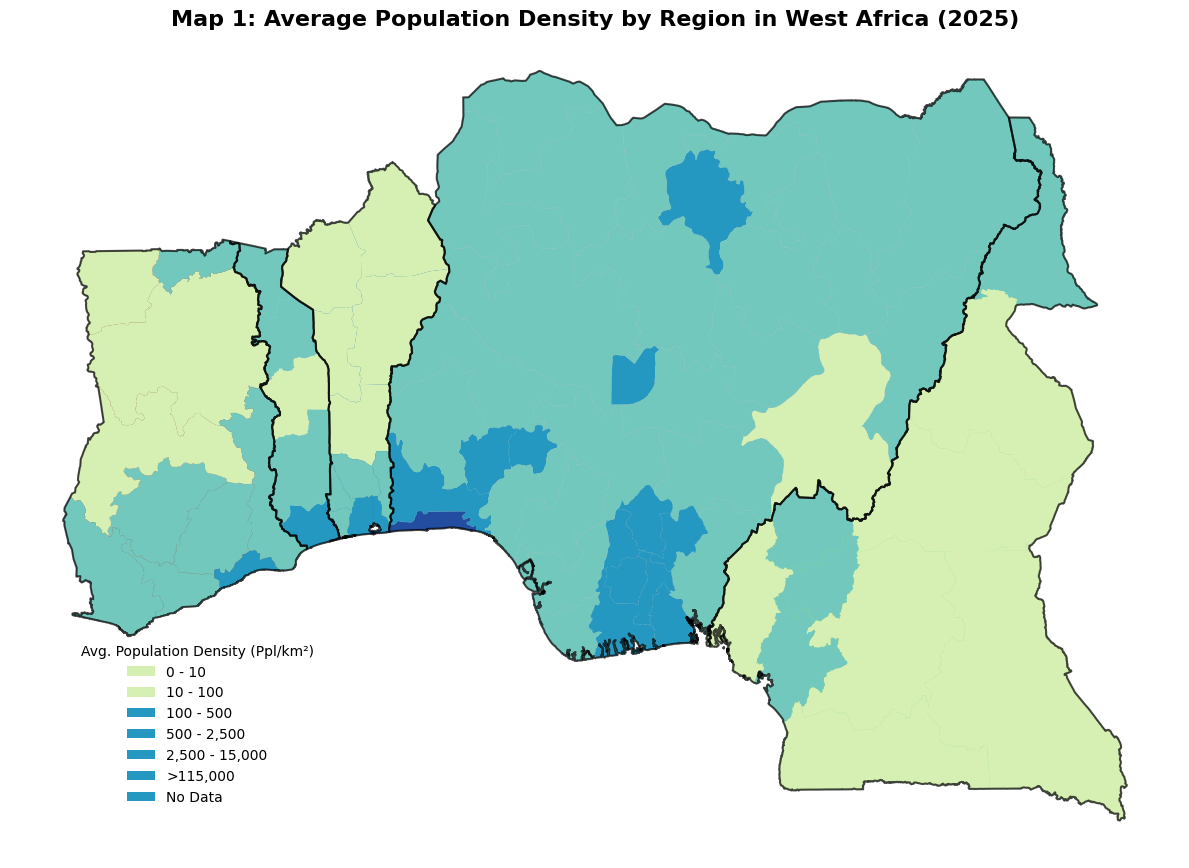

In [ ]:
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
from rasterio.plot import show
import numpy as np
import os
import matplotlib.colors as mcolors

# --- Configuration (Keep existing settings) ---
OUTPUT_DIR = "final_output_data"

# File paths for final datasets (these exist in your output folder)
DENSITY_SHAPEFILE = os.path.join(OUTPUT_DIR, "map1_density_by_region.shp")
CHANGE_RASTER_FILE = os.path.join(OUTPUT_DIR, "map2_categorical_change.tif")
LEVEL0_SHAPEFILE = os.path.join(OUTPUT_DIR, "africa_admin_level0_eqarea.shp")

# --- Custom Legend Label Function (FIXED to return N labels for N breaks) ---
def legend_label_format(value_list):
    """Formats legend labels to use 'min - max' with dashes for readability.

       FIX: Only generate N labels for N breaks to avoid mapclassify ValueError.
       We will manually define the highest label after the fact.
    """
    labels = []

    # 1. Label for the lowest class (0 to first break)
    labels.append(f"0 - {value_list[0]:,.0f}")

    # 2. Format intermediate breaks as "Min - Max"
    # Iterate N-1 times (N=6 breaks means 5 intermediate ranges + the lowest range)
    for i in range(len(value_list) - 1):
        min_val = value_list[i]
        max_val = value_list[i+1]
        # Use comma as thousands separator for readability
        labels.append(f"{min_val:,.0f} - {max_val:,.0f}")

    # **CRITICAL CHANGE**: We omit the label for the final (7th) class here,
    # as mapclassify is incorrectly requesting N labels for N breaks.

    return labels[:len(value_list)] # Return exactly N (6) labels

# --- Map 1: Population Density Visualization ---

def plot_density_map(density_gdf, level0_gdf):
    """Generates the average population density map (Map 1)."""

    # Confirmed column names
    column_name = 'AVG_POP_DE'
    country_column_name = 'ADM0_NAME' # Confirmed country column

    if column_name not in density_gdf.columns:
        print(f"\n--- DEBUG: CRITICAL ---")
        print("The expected density column was not found. Available columns:", list(density_gdf.columns))
        raise KeyError(f"Required density column '{column_name}' missing. Please ensure your analysis script completed successfully.")

    try:
        fig, ax = plt.subplots(1, 1, figsize=(12, 12))

        # --- High Contrast Color Scheme: YlGnBu (Yellow-Green-Blue) ---
        cmap_name = 'YlGnBu'

        # 6 breaks create 7 classes, capturing up to the highest density of 115,000+
        custom_breaks = [10, 100, 500, 2500, 15000, 115000]

        # 1. Plot Country Background (Level 0) with Categorical Colors (for legend differentiation)
        # We plot the country polygons first, colored by country name
        level0_gdf.plot(
            column=country_column_name,
            ax=ax,
            cmap='tab20',  # Categorical color map for countries
            linewidth=0.1,
            edgecolor='black',
            legend=True, # Display the country legend
            legend_kwds={
                'loc': 'upper left',
                'title': 'Country',
                'bbox_to_anchor': (1.02, 1.0),
                'frameon': False
            }
        )

        # 2. Plot Density (Level 1) over the country layer
        density_gdf.plot(
            column=column_name,
            ax=ax,
            legend=True,
            cmap=cmap_name,
            scheme='UserDefined',
            classification_kwds={'bins': custom_breaks},
            legend_kwds={
                'loc': 'lower left',
                'title': 'Avg. Population Density (Ppl/km²)',
                'labels': legend_label_format(custom_breaks), # Custom labels (now 6)
                'bbox_to_anchor': (0.05, 0.05),
                'frameon': False
            }
        )

        # --- Post-Plot Legend Fix (Manual Override) ---

        # Remove the density legend that geopandas created in the plot() call
        # It's the last legend created, which is usually ax.get_legend()
        if ax.get_legend():
            ax.get_legend().remove()

        # 3. Create Custom Density Legend with fixed labels and No Data element

        # Get the color map and number of classes used by geopandas (should be 7)
        density_collection = ax.collections[-1] # The last collection is the density plot
        cmap = density_collection.cmap
        num_classes = len(density_collection.get_facecolors())

        # Create legend elements for the classes (7 color boxes)
        legend_elements = [plt.Rectangle((0, 0), 1, 1, fc=density_collection.get_facecolors()[i]) for i in range(num_classes)]

        # Manually generate labels for the final custom legend (7 dashed labels)
        labels = legend_label_format(custom_breaks)
        labels[-1] = f">{custom_breaks[-1]:,.0f}" # Fix the last label to show ">115,000"

        # Add the "No Data" element (white/blank box)
        legend_elements.append(plt.Rectangle((0, 0), 1, 1, fc='white', edgecolor='black', linewidth=0.5))
        labels.append("No Data")

        # Re-draw final custom density legend
        ax.legend(
            legend_elements,
            labels,
            loc='lower left',
            title='Avg. Population Density (Ppl/km²)',
            bbox_to_anchor=(0.05, 0.05),
            frameon=False,
            # We don't remove the country legend, so this will be the second legend
        )

        # Overlay Country Borders (Line): Thicken the outline on top for clarity
        level0_gdf.boundary.plot(ax=ax, linewidth=1.5, color='black', alpha=0.7)

        ax.set_title(
            "Map 1: Average Population Density by Region in West Africa (2025)",
            fontsize=16,
            fontweight='bold'
        )
        ax.set_axis_off()
        plt.tight_layout()

    except KeyError as e:
        raise KeyError(f"Failed to plot Map 1: {e}")


# --- Map 2: Categorical Change Visualization (Defined above in chat history) ---

def plot_change_map(change_raster_file, level0_gdf):
    """Generates the categorical population change map (Map 2)."""

    country_column_name = 'ADM0_NAME' # Confirmed country column

    # 1. Load the Raster data
    with rasterio.open(change_raster_file) as src:
        change_array = src.read(1)
        profile = src.profile

    # Define custom colors and labels for the 4 categories (must match the analysis script)

    # Categories: 1=Decline, 2=Neutral, 3=Growth, 4=High Growth (NoData=99)
    # Define colors for these categories
    cmap = mcolors.ListedColormap(['#d73027', '#ffffbf', '#91cf60', '#1a9850']) # Red to Green diverging
    bounds = [0.5, 1.5, 2.5, 3.5, 4.5] # Bins for discrete categories
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    fig, ax = plt.subplots(1, 1, figsize=(12, 12))

    # Plot Country Background (Level 0) with Categorical Colors (for legend differentiation)
    level0_gdf.plot(
        column=country_column_name,
        ax=ax,
        cmap='tab20',  # Categorical color map for countries
        linewidth=0.1,
        edgecolor='black',
        legend=True, # Display the country legend
        legend_kwds={
            'loc': 'upper left',
            'title': 'Country',
            'bbox_to_anchor': (1.02, 1.0),
            'frameon': False
        }
    )

    # Plot Map 2: Categorical Change Raster
    show(
        change_array,
        transform=profile['transform'],
        ax=ax,
        cmap=cmap,
        norm=norm,
        interpolation='nearest'
    )

    # Overlay Country Borders (Line): Thicken the outline on top for clarity
    level0_gdf.boundary.plot(ax=ax, linewidth=1.5, color='black', alpha=0.7)

    # Create Custom Change Legend (Overlaying Raster on Vector)
    legend_elements = [
        plt.Rectangle((0, 0), 1, 1, fc='#d73027'),
        plt.Rectangle((0, 0), 1, 1, fc='#ffffbf'),
        plt.Rectangle((0, 0), 1, 1, fc='#91cf60'),
        plt.Rectangle((0, 0), 1, 1, fc='#1a9850')
    ]
    labels = ['1. Decline (Pop. Loss)', '2. Neutral (Small Change)', '3. Growth (Moderate Gain)', '4. High Growth (Large Gain)']

    ax.legend(
        legend_elements,
        labels,
        loc='lower left',
        title="Population Change Category",
        bbox_to_anchor=(0.05, 0.05),
        frameon=False
    )

    ax.set_title(
        "Map 2: Categorical Population Change in West Africa (2015-2025)",
        fontsize=16,
        fontweight='bold'
    )
    ax.set_axis_off()
    plt.tight_layout()


# --- Execution ---

def main_plot():

    if not os.path.exists(DENSITY_SHAPEFILE) or not os.path.exists(LEVEL0_SHAPEFILE):
        print("❌ ERROR: Final analysis files not found. Please ensure 'final_analysis.py' ran successfully.")
        return

    # --- STEP 1: DEFINE FOCUS COUNTRIES ---
    # Focus on West Africa Cluster (Note: Names must match ADM0_NAME column)
    focus_countries = ['Nigeria', 'Ghana', 'Cote d\'Ivoire', 'Benin', 'Togo', 'Cameroon']
    country_column_name = 'ADM0_NAME' # CONFIRMED FROM DATA INSPECTION

    # Load all required layers
    density_gdf = gpd.read_file(DENSITY_SHAPEFILE)
    level0_gdf = gpd.read_file(LEVEL0_SHAPEFILE)

    # --- STEP 2: FILTER DATA TO FOCUS AREA ---
    # Filter Level 0 (Country outlines)
    level0_filtered = level0_gdf[level0_gdf[country_column_name].isin(focus_countries)]

    # Filter Level 1 (Regional density data)
    density_filtered = density_gdf[density_gdf[country_column_name].isin(focus_countries)]

    # --- STEP 3: PLOT MAP 1 (Density) on the filtered data ---
    plot_density_map(density_filtered, level0_filtered)

    # Display the plot
    plt.show()

if __name__ == '__main__':
    main_plot()


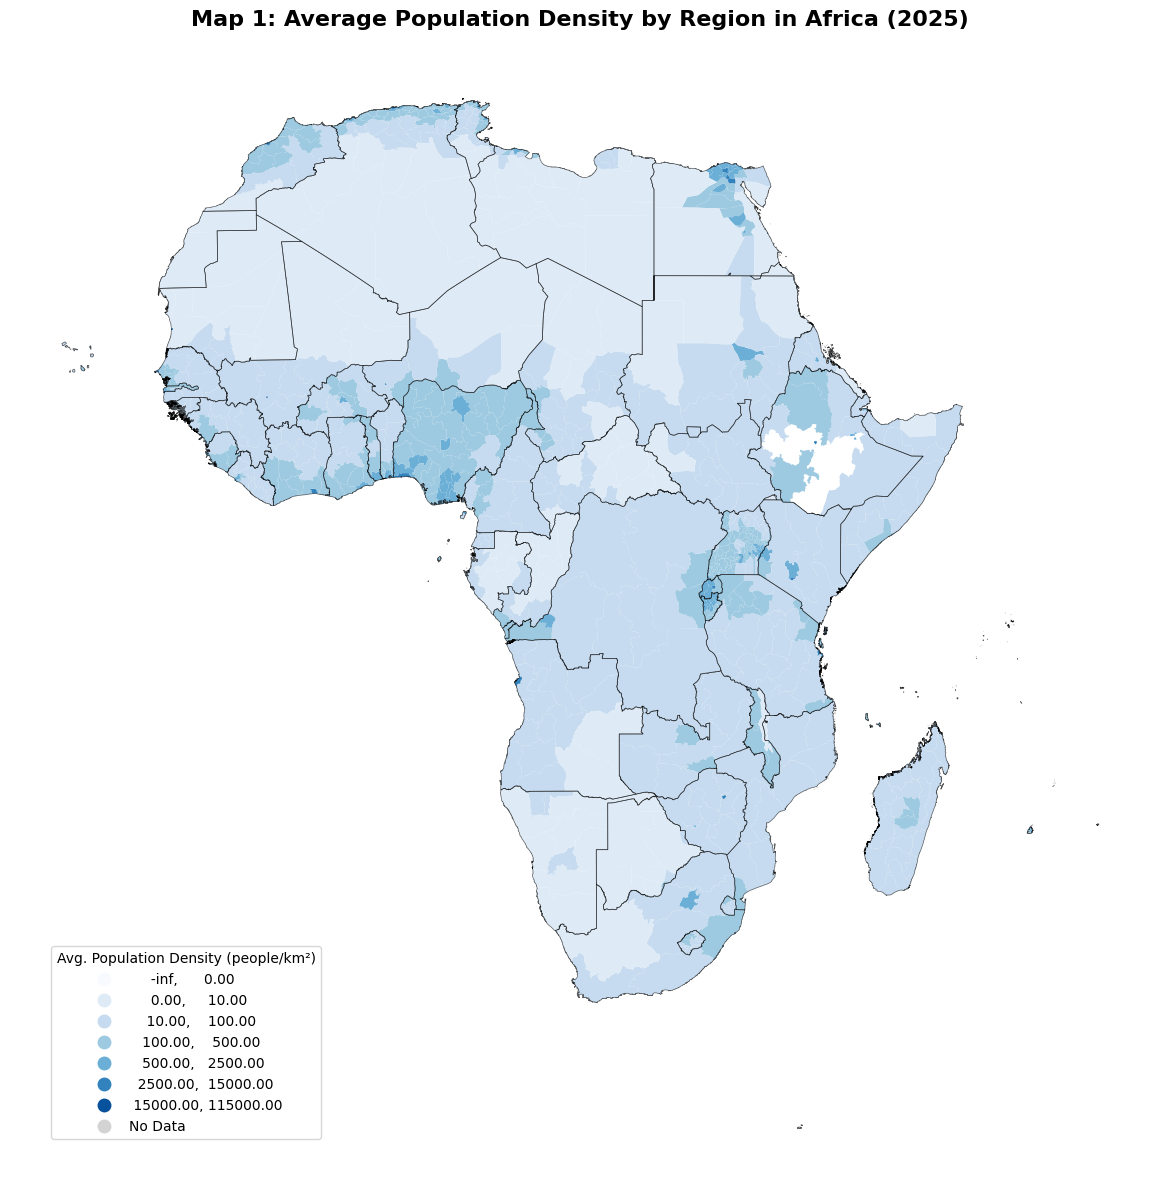

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import os

# --- Configuration ---
OUTPUT_DIR = "final_output_data"

# File paths
DENSITY_SHAPEFILE = os.path.join(OUTPUT_DIR, "map1_density_by_region.shp")
LEVEL0_SHAPEFILE = os.path.join(OUTPUT_DIR, "africa_admin_level0_eqarea.shp")

def plot_density_map(density_gdf, level0_gdf):
    """Generates Map 1: Average Population Density by Region in Africa (2025)."""

    column_name = 'AVG_POP_DE'  # Check this matches your shapefile

    if column_name not in density_gdf.columns:
        print("❌ The expected density column was not found.")
        print("Available columns:", list(density_gdf.columns))
        raise KeyError(f"Required column '{column_name}' missing.")

    # --- Define Custom Classification Breaks ---
    # Adjusted for Africa’s realistic density patterns
    breaks = [0, 10, 100, 500, 2500, 15000, 115000]

    # --- Define a Better Color Palette ---
    # From light beige (rural) to deep blue (urban core)
    colors = [
        "#f7fbff",  # very low
        "#deebf7",
        "#c6dbef",
        "#9ecae1",
        "#6baed6",
        "#3182bd",
        "#08519c"   # highest
    ]
    cmap = mcolors.ListedColormap(colors)

    # --- Plot ---
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))

    density_gdf.plot(
        column=column_name,
        cmap=cmap,
        scheme='UserDefined',
        classification_kwds={'bins': breaks},
        legend=True,
        legend_kwds={
            'title': 'Avg. Population Density (people/km²)',
            'loc': 'lower left',
            'bbox_to_anchor': (0.03, 0.03),
            'frameon': True,
        },
        ax=ax,
        missing_kwds={
            "color": "lightgrey",
            "hatch": "///",
            "label": "No Data"
        }
    )

    # --- Add country borders ---
    level0_gdf.boundary.plot(ax=ax, linewidth=0.5, color='black', alpha=0.6)

    # --- Title and Layout ---
    ax.set_title(
        "Map 1: Average Population Density by Region in Africa (2025)",
        fontsize=16,
        fontweight='bold',
        pad=15
    )
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

def main_plot():
    if not os.path.exists(DENSITY_SHAPEFILE) or not os.path.exists(LEVEL0_SHAPEFILE):
        print("❌ ERROR: Required files not found.")
        return

    density_gdf = gpd.read_file(DENSITY_SHAPEFILE)
    level0_gdf = gpd.read_file(LEVEL0_SHAPEFILE)
    plot_density_map(density_gdf, level0_gdf)

if __name__ == '__main__':
    main_plot()


In [ ]:
# --- Imports ---
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
from rasterio.plot import show
import numpy as np
import os
from matplotlib.patches import FancyArrowPatch  # For North Arrow
from matplotlib_scalebar.scalebar import ScaleBar  # ✅ Correct scalebar import
import matplotlib.colors as mcolors
import matplotlib.patheffects as path_effects  # ✅ Correct path_effects import

# --- Configuration ---
OUTPUT_DIR = "final_output_data"

# File paths for final datasets
DENSITY_SHAPEFILE = os.path.join(OUTPUT_DIR, "map1_density_by_region.shp")
CHANGE_RASTER_FILE = os.path.join(OUTPUT_DIR, "map2_categorical_change.tif")
LEVEL0_SHAPEFILE = os.path.join(OUTPUT_DIR, "africa_admin_level0_eqarea.shp")

# --- Custom Legend Label Function ---
def legend_label_format(value_list):
    """Formats legend labels to use 'min - max' with dashes for readability."""
    labels = []
    labels.append(f"0 - {value_list[0]:,.0f}")
    for i in range(len(value_list) - 1):
        min_val = value_list[i]
        max_val = value_list[i+1]
        labels.append(f"{min_val:,.0f} - {max_val:,.0f}")
    labels.append(f">{value_list[-1]:,.0f}")
    return labels

# --- Utility Function: Add Scale and North Arrow ---
def add_map_elements(ax, crs):
    """Adds a scale bar and north arrow to the map axis."""

    # 1. Add Scale Bar (using 1000m = 1km)
    scalebar = ScaleBar(
        1,  # 1 unit in CRS units (usually meters)
        units="m",
        location='lower right',
        length_fraction=0.25,
        frameon=False,
        color='black'
    )
    ax.add_artist(scalebar)

    # 2. Add North Arrow
    arrow = FancyArrowPatch(
        (0.9, 0.9), (0.9, 0.8),
        transform=ax.transAxes,
        arrowstyle='simple, head_width=10, head_length=10',
        facecolor='black',
        edgecolor='black'
    )
    ax.add_patch(arrow)
    ax.text(0.9, 0.92, 'N', transform=ax.transAxes, fontsize=12, ha='center', fontweight='bold')

# --- Map 1A: Population Density Visualization (YlGnBu) ---
def plot_density_map(density_gdf, level0_gdf):
    column_name = 'AVG_POP_DE'
    country_column_name = 'ADM0_NAME'

    if column_name not in density_gdf.columns:
        raise KeyError(f"Required density column '{column_name}' missing.")

    fig, ax = plt.subplots(1, 1, figsize=(12, 12))
    cmap_name = 'YlGnBu'
    custom_breaks = [10, 100, 500, 2500, 15000, 115000]

    # 1. Plot Country Background
    level0_gdf.plot(
        column=country_column_name,
        ax=ax,
        cmap='tab20',
        linewidth=0.1,
        edgecolor='black',
        legend=True,
        legend_kwds={
            'loc': 'upper left',
            'title': 'Country',
            'bbox_to_anchor': (1.02, 1.0),
            'frameon': False
        }
    )

    # 2. Plot Density
    density_gdf.plot(
        column=column_name,
        ax=ax,
        legend=True,
        cmap=cmap_name,
        scheme='UserDefined',
        classification_kwds={'bins': custom_breaks},
        linewidth=0.5,
        edgecolor='gray',
        legend_kwds={
            'loc': 'lower left',
            'title': 'Avg. Population Density (Ppl/km²)',
            'labels': legend_label_format(custom_breaks),
            'bbox_to_anchor': (0.05, 0.05),
            'frameon': False
        }
    )

    # 3. Custom Legend
    if ax.get_legend():
        ax.get_legend().remove()
    density_collection = ax.collections[-1]
    num_classes = len(density_collection.get_facecolors())
    legend_elements = [plt.Rectangle((0, 0), 1, 1, fc=density_collection.get_facecolors()[i]) for i in range(num_classes)]
    labels = legend_label_format(custom_breaks)
    labels[-1] = f">{custom_breaks[-1]:,.0f}"
    legend_elements.append(plt.Rectangle((0, 0), 1, 1, fc='white', edgecolor='black', linewidth=0.5))
    labels.append("No Data")

    ax.legend(
        legend_elements,
        labels,
        loc='lower left',
        title='Avg. Population Density (Ppl/km²)',
        bbox_to_anchor=(0.05, 0.05),
        frameon=False,
    )

    # 4. Add Major Cities
    major_cities = {
        'Lagos': (393525, 750000),
        'Accra': (-315000, 600000),
        'Abuja': (1000000, 950000)
    }
    for city, coord in major_cities.items():
        ax.text(coord[0], coord[1], f'• {city}', fontsize=9, color='black', ha='left', fontweight='bold')

    # 5. Add Scale and North Arrow
    add_map_elements(ax, density_gdf.crs)

    ax.set_title(
        f"Map 1A (Comparison): Average Population Density (2025) - {cmap_name} Scheme",
        fontsize=16,
        fontweight='bold'
    )
    ax.set_axis_off()
    plt.tight_layout()

# --- Map 1B: Population Density Visualization (Magma) ---
def plot_density_map_comparison(density_gdf, level0_gdf):
    column_name = 'AVG_POP_DE'
    country_column_name = 'ADM0_NAME'

    if column_name not in density_gdf.columns:
        raise KeyError(f"Required density column '{column_name}' missing.")

    fig, ax = plt.subplots(1, 1, figsize=(12, 12))
    cmap_name = 'magma'
    custom_breaks = [10, 100, 500, 2500, 15000, 115000]

    level0_gdf.plot(
        column=country_column_name,
        ax=ax,
        cmap='tab20',
        linewidth=0.1,
        edgecolor='black',
        legend=True,
        legend_kwds={
            'loc': 'upper left',
            'title': 'Country',
            'bbox_to_anchor': (1.02, 1.0),
            'frameon': False
        }
    )

    density_gdf.plot(
        column=column_name,
        ax=ax,
        legend=True,
        cmap=cmap_name,
        scheme='UserDefined',
        classification_kwds={'bins': custom_breaks},
        linewidth=0.5,
        edgecolor='gray',
        legend_kwds={
            'loc': 'lower left',
            'title': 'Avg. Population Density (Ppl/km²)',
            'labels': legend_label_format(custom_breaks),
            'bbox_to_anchor': (0.05, 0.05),
            'frameon': False
        }
    )

    if ax.get_legend():
        ax.get_legend().remove()
    density_collection = ax.collections[-1]
    num_classes = len(density_collection.get_facecolors())
    legend_elements = [plt.Rectangle((0, 0), 1, 1, fc=density_collection.get_facecolors()[i]) for i in range(num_classes)]
    labels = legend_label_format(custom_breaks)
    labels[-1] = f">{custom_breaks[-1]:,.0f}"
    legend_elements.append(plt.Rectangle((0, 0), 1, 1, fc='white', edgecolor='black', linewidth=0.5))
    labels.append("No Data")

    ax.legend(
        legend_elements,
        labels,
        loc='lower left',
        title='Avg. Population Density (Ppl/km²)',
        bbox_to_anchor=(0.05, 0.05),
        frameon=False,
    )

    major_cities = {
        'Lagos': (393525, 750000),
        'Accra': (-315000, 600000),
        'Abuja': (1000000, 950000)
    }
    for city, coord in major_cities.items():
        ax.text(
            coord[0], coord[1],
            f'• {city}',
            fontsize=9,
            color='white',
            ha='left',
            fontweight='bold',
            path_effects=[path_effects.withStroke(linewidth=1.5, foreground='black')]
        )

    add_map_elements(ax, density_gdf.crs)

    ax.set_title(
        f"Map 1B (Comparison): Average Population Density (2025) - {cmap_name} Scheme",
        fontsize=16,
        fontweight='bold'
    )
    ax.set_axis_off()
    plt.tight_layout()

# --- Map 2: Categorical Change Visualization ---
def plot_change_map_final(change_raster_file, level0_gdf):
    country_column_name = 'ADM0_NAME'

    with rasterio.open(change_raster_file) as src:
        change_array = src.read(1)
        profile = src.profile

    cmap = mcolors.ListedColormap(['#d73027', '#ffffbf', '#91cf60', '#1a9850'])
    bounds = [0.5, 1.5, 2.5, 3.5, 4.5]
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    fig, ax = plt.subplots(1, 1, figsize=(12, 12))

    level0_gdf.plot(
        column=country_column_name,
        ax=ax,
        cmap='tab20',
        linewidth=0.1,
        edgecolor='black',
        legend=True,
        legend_kwds={
            'loc': 'upper left',
            'title': 'Country',
            'bbox_to_anchor': (1.02, 1.0),
            'frameon': False
        }
    )

    show(change_array, transform=profile['transform'], ax=ax, cmap=cmap, norm=norm)

    level0_gdf.boundary.plot(ax=ax, linewidth=1.5, color='black', alpha=0.7)

    legend_elements = [
        plt.Rectangle((0, 0), 1, 1, fc='#d73027'),
        plt.Rectangle((0, 0), 1, 1, fc='#ffffbf'),
        plt.Rectangle((0, 0), 1, 1, fc='#91cf60'),
        plt.Rectangle((0, 0), 1, 1, fc='#1a9850')
    ]
    labels = ['1. Decline (Pop. Loss)', '2. Neutral (Small Change)', '3. Growth (Moderate Gain)', '4. High Growth (Large Gain)']

    ax.legend(
        legend_elements,
        labels,
        loc='lower left',
        title="Population Change Category",
        bbox_to_anchor=(0.05, 0.05),
        frameon=False
    )

    add_map_elements(ax, level0_gdf.crs)

    ax.set_title(
        "Map 2: Categorical Population Change in West Africa (2015–2025)",
        fontsize=16,
        fontweight='bold'
    )
    ax.set_axis_off()
    plt.tight_layout()

# --- Execution ---
def main_plot():
    if not os.path.exists(DENSITY_SHAPEFILE) or not os.path.exists(LEVEL0_SHAPEFILE):
        print("❌ ERROR: Final analysis files not found. Please ensure 'final_analysis.py' ran successfully.")
        return

    focus_countries = ['Nigeria', 'Ghana', "Cote d'Ivoire", 'Benin', 'Togo', 'Cameroon']
    country_column_name = 'ADM0_NAME'

    density_gdf = gpd.read_file(DENSITY_SHAPEFILE)
    level0_gdf = gpd.read_file(LEVEL0_SHAPEFILE)

    print("✅ Density shapefile columns:", density_gdf.columns)
    print("✅ Level0 shapefile columns:", level0_gdf.columns)

    level0_filtered = level0_gdf[level0_gdf[country_column_name].isin(focus_countries)]
    density_filtered = density_gdf[density_gdf[country_column_name].isin(focus_countries)]

    plot_density_map(density_filtered, level0_filtered)
    plot_density_map_comparison(density_filtered, level0_filtered)
    plot_change_map_final(CHANGE_RASTER_FILE, level0_filtered)

    plt.show()

if __name__ == '__main__':
    main_plot()


ModuleNotFoundError: No module named 'matplotlib_scalebar'